<a href="https://colab.research.google.com/github/its-parmiss/-Django-Twitter-Backend---Internet-Engineering-Course-2021-Project/blob/main/Comp_6721_Course_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comp 6721 course project.

Team G05

Dataset: [Bank marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

>[imports](#scrollTo=8DYe-ei1YPkF)

>[getting the data](#scrollTo=PrXrOAnvVoGK)

>[Part 1 : Descriptive and exploratory data analysis (EDA)](#scrollTo=twZBFgBQMHOl)

>[Part 2 : Data Preprocessing](#scrollTo=tfkjSECDMiEX)

>[Part 3 : implement the model](#scrollTo=t9OFO-pxMp8J)

>[I. Supervised learning Classification with Decision Trees](#scrollTo=acShpzehMQmT)

>>>[Optimization for the Decision Tree classifier](#scrollTo=MHuRNRskr3UF)

>[II. Semi-supervised learning Classification with Decision Trees](#scrollTo=EKoYS94aMglT)

>[III. Supervised learning Classification with a deep learning Model](#scrollTo=nhzCWumnM_pz)

>>[Optimization for the DNN model](#scrollTo=H66hv_8ENFCI)

>[Optimization Techniques:](#scrollTo=uAbAo4WWFwsU)

>>[performing gridsearch to find best configuration for DNN](#scrollTo=bDxPdY3qWM0Z)

>>[Training the model with the best configuration ( Final DNN model and results)](#scrollTo=h1h5gf-_WB_8)

>[Comparing results for different models](#scrollTo=UpPiYkgTtZNU)



# **imports**

In [1]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install graphviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install skorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 16.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import requests
from io import BytesIO
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
fbeta_score,
confusion_matrix,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import random
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
import itertools
import torch.nn.init as init
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from skorch import NeuralNetClassifier
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import time
from torchvision.models import resnet50
from thop import profile
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier

# **getting the data**

In [5]:
#loading the data

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

response = requests.get(url)

zip_file = zipfile.ZipFile(BytesIO(response.content))

csv_file = zip_file.open('bank-full.csv')

df = pd.read_csv(csv_file, delimiter=';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
numerical_features = ['age', 'balance', 'campaign', 'duration', 'pdays', 'previous']
num_features = [0, 5, 9, 11, 12, 13, 14]
cat_features = [1, 2, 3, 4, 6, 7, 8, 10, 15]

# **Part 1 : Descriptive and exploratory data analysis (EDA)**

The dataset contains the following attributes:

Age

Job

Marital status

Education

Default: Has credit in default?

Housing: Has a housing loan?

Loan: Has a personal loan?

Contact: Contact communication type

Month: Last contact month of the year

Day of week: Last contact day of the week

Duration: Last contact duration in seconds

Campaign: Number of contacts performed during this campaign for the client

Pdays: Number of days that passed after the client was last contacted from a previous campaign

Previous: Number of contacts performed before this campaign and for this client

Poutcome: Outcome of the previous marketing campaign

y : did client subscribe to a term deposit?

In [7]:
columns = df.columns.tolist()

# Print column names with their distinct values
for column in columns:
    distinct_values = df[column].unique()
    num_distinct_values = len(distinct_values)

    if np.issubdtype(df[column].dtype, np.number):
        data_type = "Numerical"
    else:
        data_type = "Categorical"
        distinct_value_str = ', '.join(map(str, distinct_values))

    print(f"{column}: {data_type} ({num_distinct_values} distinct values)")

    if data_type == "Categorical":
        print(f"Distinct values: {distinct_value_str}")
    print("")

age: Numerical (77 distinct values)

job: Categorical (12 distinct values)
Distinct values: management, technician, entrepreneur, blue-collar, unknown, retired, admin., services, self-employed, unemployed, housemaid, student

marital: Categorical (3 distinct values)
Distinct values: married, single, divorced

education: Categorical (4 distinct values)
Distinct values: tertiary, secondary, unknown, primary

default: Categorical (2 distinct values)
Distinct values: no, yes

balance: Numerical (7168 distinct values)

housing: Categorical (2 distinct values)
Distinct values: yes, no

loan: Categorical (2 distinct values)
Distinct values: no, yes

contact: Categorical (3 distinct values)
Distinct values: unknown, cellular, telephone

day: Numerical (31 distinct values)

month: Categorical (12 distinct values)
Distinct values: may, jun, jul, aug, oct, nov, dec, jan, feb, mar, apr, sep

duration: Numerical (1573 distinct values)

campaign: Numerical (48 distinct values)

pdays: Numerical (559

In [8]:
# number of rows in dataset

print("number of rows in the dataset: {rows}.".format(rows = len(df)))

number of rows in the dataset: 45211.


In [9]:
#column description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [10]:
# Check for missing values using isna()
missing_values = df.isna()

print(missing_values.sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [11]:
# Summary statistics of numerical variables
print(df.describe())

                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.

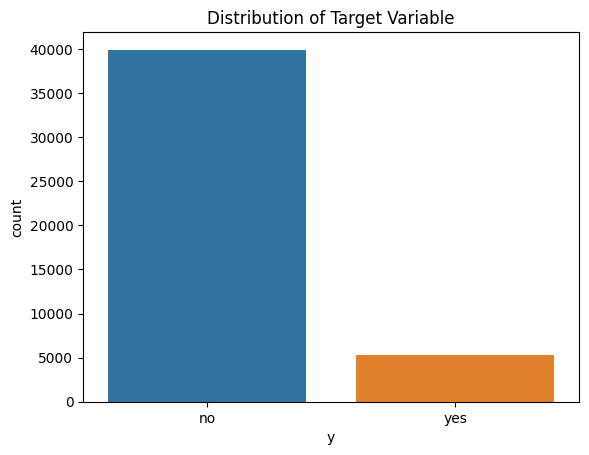

In [12]:
# Distribution of the target variable

# It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns.
# First of all we should look at the number of 'yes' and 'no' values in the response column 'y'.
sns.countplot(x='y', data=df)
plt.title('Distribution of Target Variable')
plt.show()

from the above distribution, we can observe that the dataset is imbalanced, with a significantly higher number of instances where the client did not subscribe to a term deposit compared to instances where they did. This class imbalance could potentially impact the performance and accuracy of predictive models trained on this dataset.

In [13]:
# Calculate the distribution of numerical variables
num_cols = [column for column in df.columns if np.issubdtype(df[column].dtype, np.number)]

numerical_distribution = df[num_cols].describe()

print(numerical_distribution)


                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.

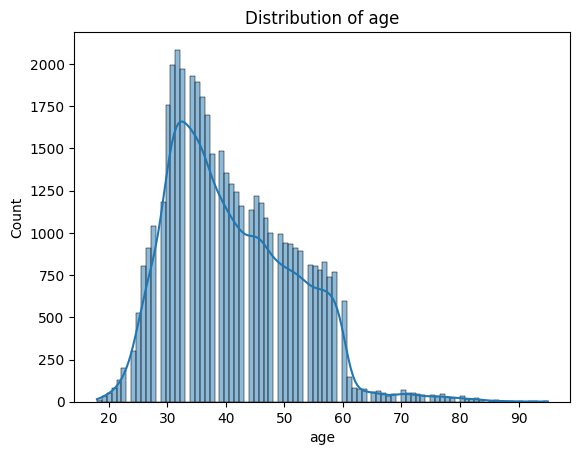

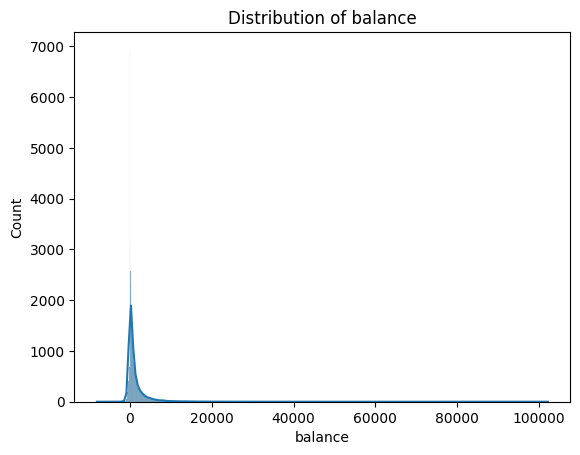

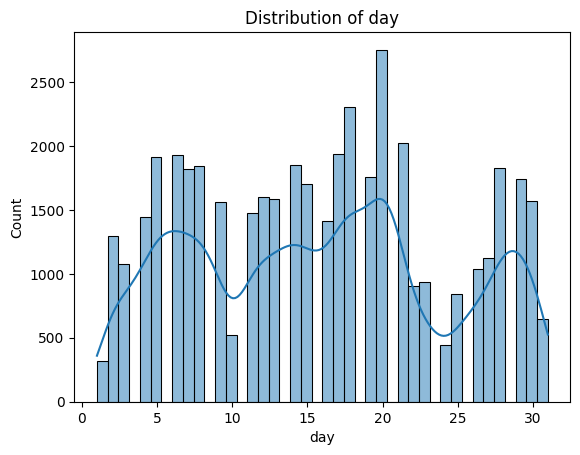

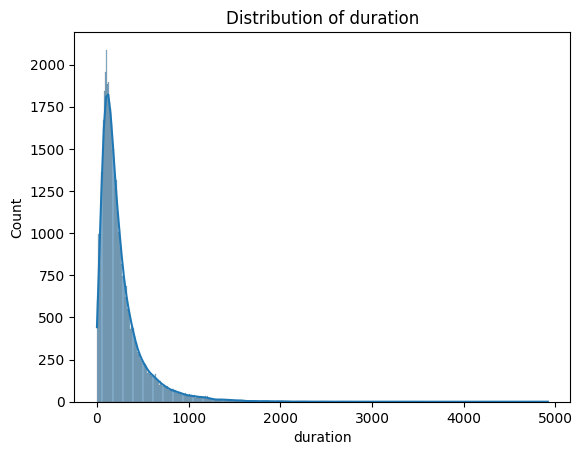

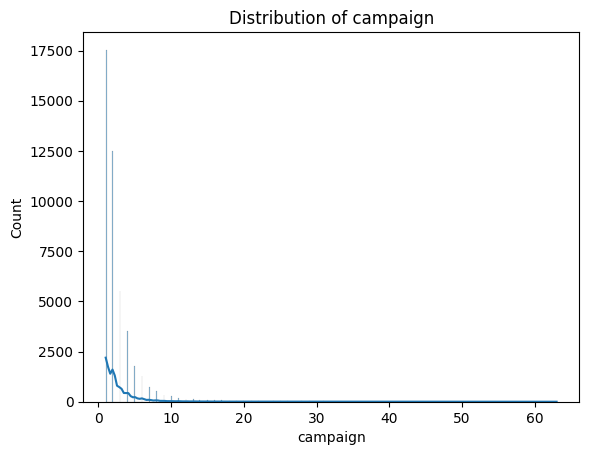

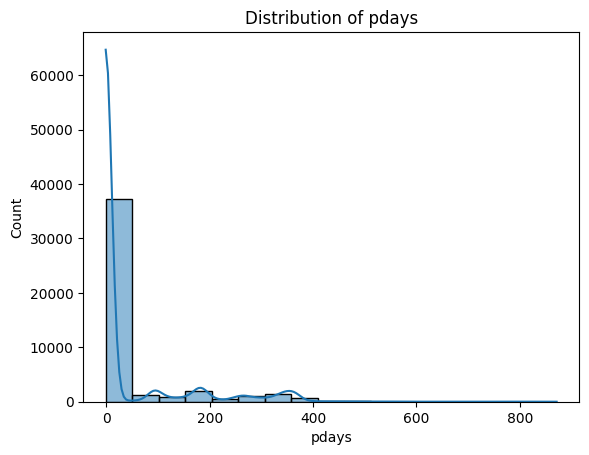

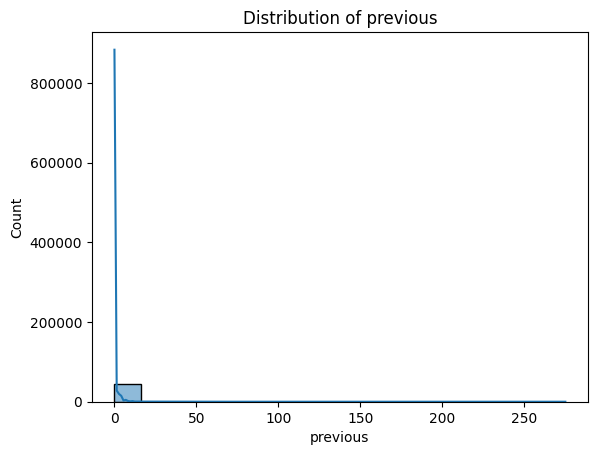

In [14]:
# Visualize the distribution of numerical variables
for col in num_cols:
    plt.figure()
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [15]:

Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)

IQR = Q3 - Q1

# Identify potential outliers
outliers = ((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any()

features_with_outliers = outliers[outliers == True].index.tolist()

print("Numerical features with potential outliers:")
print(features_with_outliers)


Numerical features with potential outliers:
['age', 'balance', 'campaign', 'duration', 'pdays', 'previous']


**observations**

The minimum value for pday is -1, which could represent missing data or clients who were not previously contacted.
The 25th, 50th, and 75th percentiles are all -1, indicating that a significant portion of the values are -1. we can consider replacing them with nan in our preprocessing steps.
we can also see from the charts that pdays contains outliers,because we have a very few records containing pdays more than 400. . These outliers could potentially influence the model's performance and should be considered during preprocessing.

There are some outliers or noisy values in the 'campaign' column, specifically those above 34, which are considered as noise.so we can consider imputing them with average campaign values in the data preprocessing step




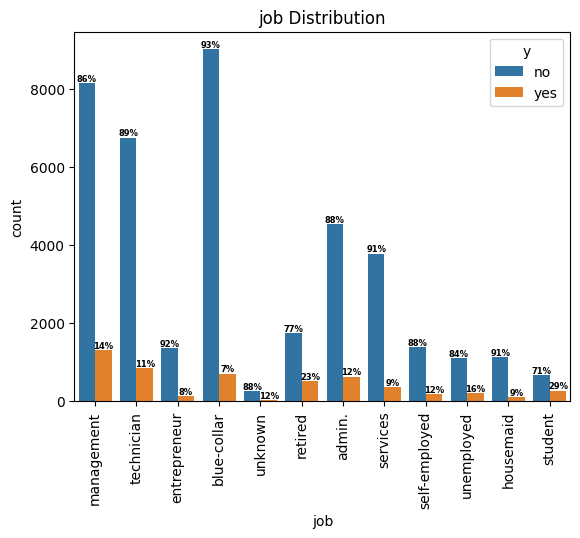

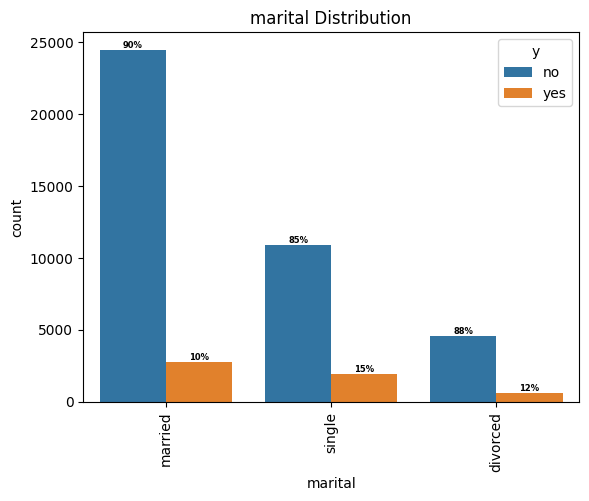

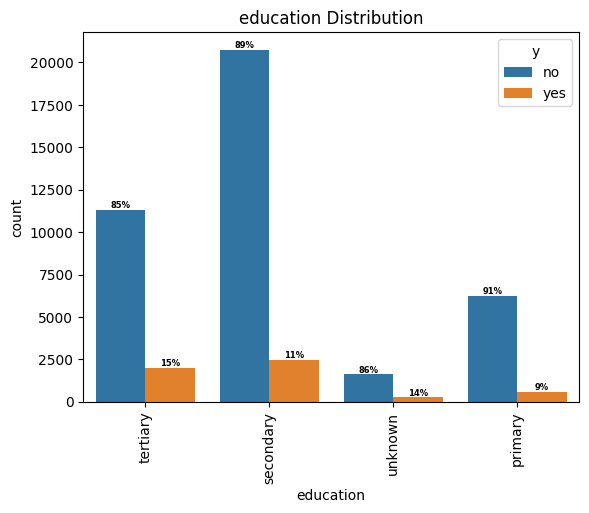

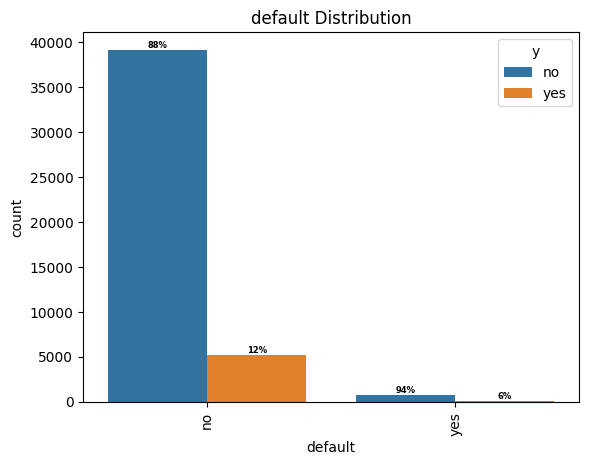

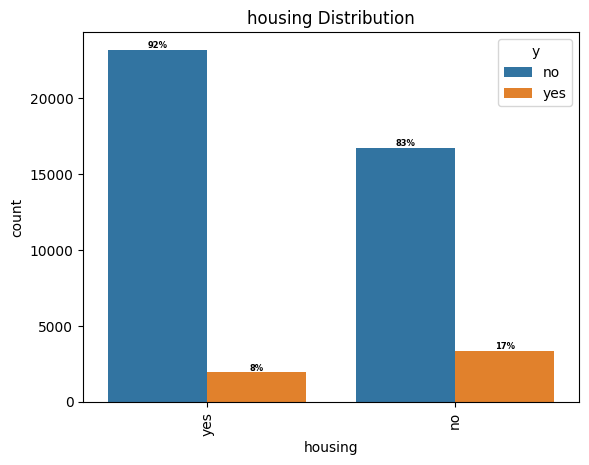

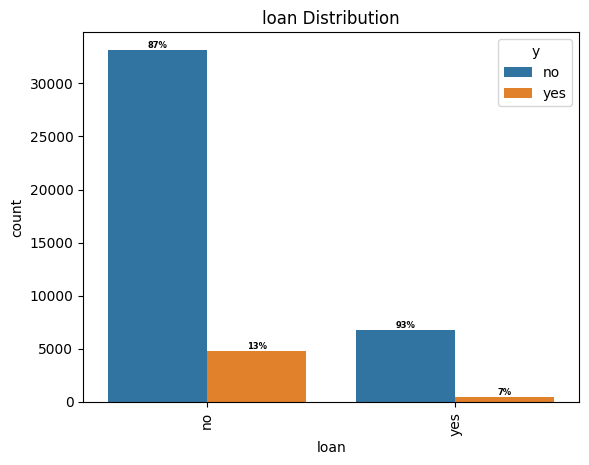

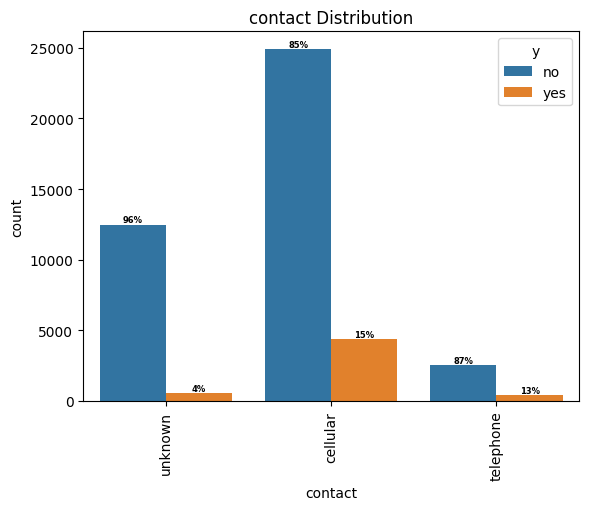

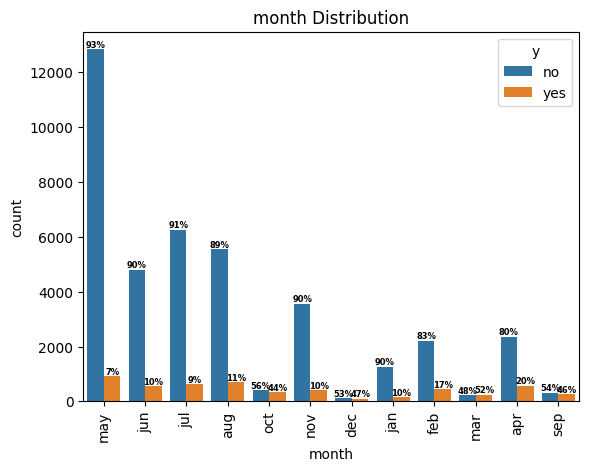

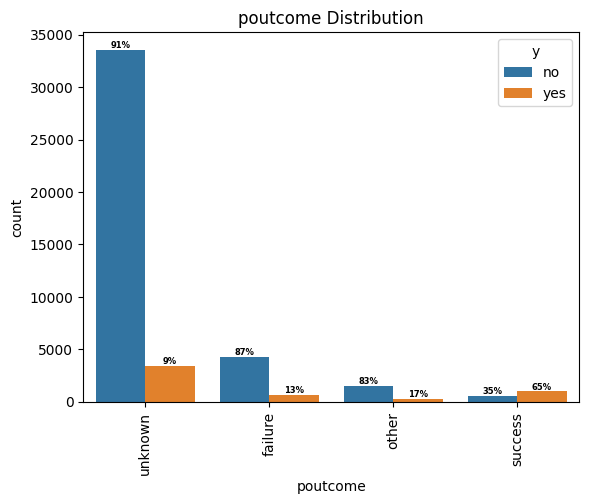

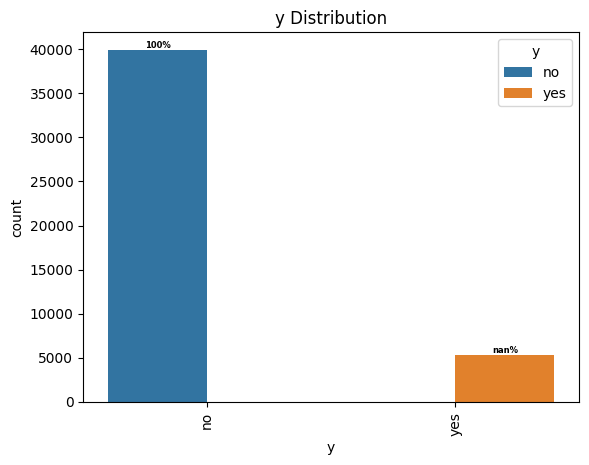

In [16]:

cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    plt.figure()
    ax = sns.countplot(data=df, x=col, hue='y')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=90)

    percentages = df.groupby([col, 'y']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)

    # Add percentage labels to the bars
    category_num=0
    yes_round=0
    for p in ax.patches:

        height = p.get_height()
        if height > 0:
            x = p.get_x() + p.get_width() / 2
            y = height

            category = ax.get_xticklabels()[category_num].get_text()
            percentage_yes = percentages.loc[category, 'yes']
            percentage_no = percentages.loc[category, 'no']
            facecolor = p.get_facecolor()
            if yes_round==0:

                label_text = f'{percentage_no:.0f}%'
            else:
                label_text = f'{percentage_yes:.0f}%'
            ax.text(x, y, label_text, ha='center', va='bottom', color='black', fontsize=6, weight='bold')
            category_num=category_num+1
            if category_num==len(ax.get_xticklabels()):

              category_num=0
              yes_round=1

    plt.show()


In [17]:
len(ax.get_xticklabels())

2

**observations**

Firstly, customers without a personal loan demonstrated a higher response rate, indicating that the absence of a loan is positively correlated with a better campaign outcome. Secondly, customers who did not have housing also showed a stronger response, suggesting that housing status plays a role in customer engagement. Additionally, customers with a default history of "no" exhibited better response rates compared to those with a default history of "yes." Furthermore, students and retired individuals stood out with notably higher response rates compared to other occupations, while entrepreneurs, blue-collar workers, housemaids, and services job holders responded the least. These findings emphasize the significance of considering variables such as loan status, housing, default history, and occupation when designing targeted marketing strategies.

<ipython-input-18-7cab157e3f0d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


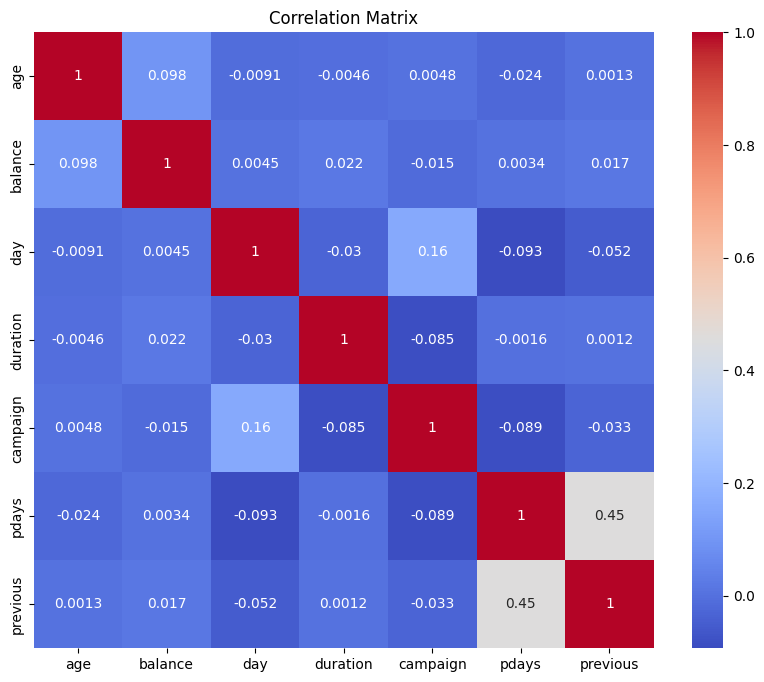

In [18]:
# Correlation matrix of numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **Part 2 : Data Preprocessing**

Based on our analysis of the Bank Marketing dataset, the following preprocessing steps are recommended for the classification problem using decision trees:

Handling Missing Values: Replace -1 values in the "pdays" column with NaN using df['pdays'].replace(-1, np.nan, inplace=True).

Encoding Categorical Variables: Apply one-hot encoding to convert categorical variables into binary columns using pd.get_dummies(df).

Dealing with Outliers: Investigate and address potential outliers in numerical columns ('age', 'balance', 'campaign', 'duration', 'pdays', 'previous') using appropriate methods such as Winsorization, truncation, or removal.

Handling Imbalanced Data: Address the class imbalance issue by employing techniques such as oversampling the minority class (e.g., SMOTE) or undersampling the majority class to balance the dataset.

Feature Scaling: Consider applying feature scaling to numerical columns using techniques like standardization or normalization to ensure variables are on a similar scale. Note that this step may not be necessary for decision trees, but it may be beneficial for other algorithms like MLP.

Feature Selection: Analyze feature relevance and importance using techniques such as correlation analysis or feature importance ranking to select the most informative features for the decision tree model.

In [19]:
df_copy=df.copy()

In [20]:
df = df_copy.copy()

# Replace 'unknown' values with NaN
df.replace('unknown', np.nan, inplace=True)
df['pdays'].replace(-1, np.nan, inplace=True)
# Handle missing values in columns by replacing them with the most frequent value
columns_with_missing_values = df.columns[df.isna().any()]
print(columns_with_missing_values)
imputer = SimpleImputer(strategy="most_frequent")
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])


# # Apply one-hot encoding to categorical columns



label_encoder = LabelEncoder()

for i in cat_features:
    df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])

X = df.drop('y', axis=1)
y = df['y']


X.head()

Index(['job', 'education', 'contact', 'pdays', 'poutcome'], dtype='object')


<ipython-input-20-27df91ec921d>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])
<ipython-input-20-27df91ec921d>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, i] = label_encoder.fit_transform(df.iloc[:, i])
<ipython-input-20-27df91ec921d>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,182.0,0,0
1,44,9,2,1,0,29,1,0,0,5,8,151,1,182.0,0,0
2,33,2,1,1,0,2,1,1,0,5,8,76,1,182.0,0,0
3,47,1,1,1,0,1506,1,0,0,5,8,92,1,182.0,0,0
4,33,1,2,1,0,1,0,0,0,5,8,198,1,182.0,0,0


In [21]:
print(y)

0         no
1         no
2         no
3         no
4         no
        ... 
45206    yes
45207    yes
45208    yes
45209     no
45210     no
Name: y, Length: 45211, dtype: object


In [22]:
df_cleaned=df.copy()

In [23]:
columns = ['Model', 'Train Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cross Validation']
model_results = pd.DataFrame(columns=columns)

# **Part 3 : implement the model**




# **I. Supervised learning Classification with Decision Trees**

the following code is not the final model, it is the innitial attempt, the code for the final model is in the next section, after the optimization.

In [24]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
#define hyper parameters

max_depth=3
criterion= 'entropy'
random_state=25
dt_classifier = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
dt_classifier.fit(x_train, y_train)
y_pred = dt_classifier.predict(x_test)

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train_en = dt_classifier.predict(x_train)

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train_en = dt_classifier.predict(x_train)



Model accuracy score with criterion entropy: 0.9021
Model accuracy score with criterion entropy: 0.9021


[Text(0.5, 0.875, 'x[11] <= 364.5\nentropy = 0.523\nsamples = 36168\nvalue = [31904, 4264]'),
 Text(0.25, 0.625, 'x[15] <= 1.5\nentropy = 0.336\nsamples = 28841\nvalue = [27049, 1792]'),
 Text(0.125, 0.375, 'x[6] <= 0.5\nentropy = 0.266\nsamples = 27957\nvalue = [26694, 1263]'),
 Text(0.0625, 0.125, 'entropy = 0.403\nsamples = 12130\nvalue = [11156, 974]'),
 Text(0.1875, 0.125, 'entropy = 0.132\nsamples = 15827\nvalue = [15538, 289]'),
 Text(0.375, 0.375, 'x[11] <= 132.0\nentropy = 0.972\nsamples = 884\nvalue = [355, 529]'),
 Text(0.3125, 0.125, 'entropy = 0.77\nsamples = 195\nvalue = [151, 44]'),
 Text(0.4375, 0.125, 'entropy = 0.876\nsamples = 689\nvalue = [204, 485]'),
 Text(0.75, 0.625, 'x[11] <= 648.5\nentropy = 0.922\nsamples = 7327\nvalue = [4855, 2472]'),
 Text(0.625, 0.375, 'x[15] <= 1.5\nentropy = 0.795\nsamples = 4749\nvalue = [3608, 1141]'),
 Text(0.5625, 0.125, 'entropy = 0.746\nsamples = 4521\nvalue = [3560, 961]'),
 Text(0.6875, 0.125, 'entropy = 0.742\nsamples = 228\nva

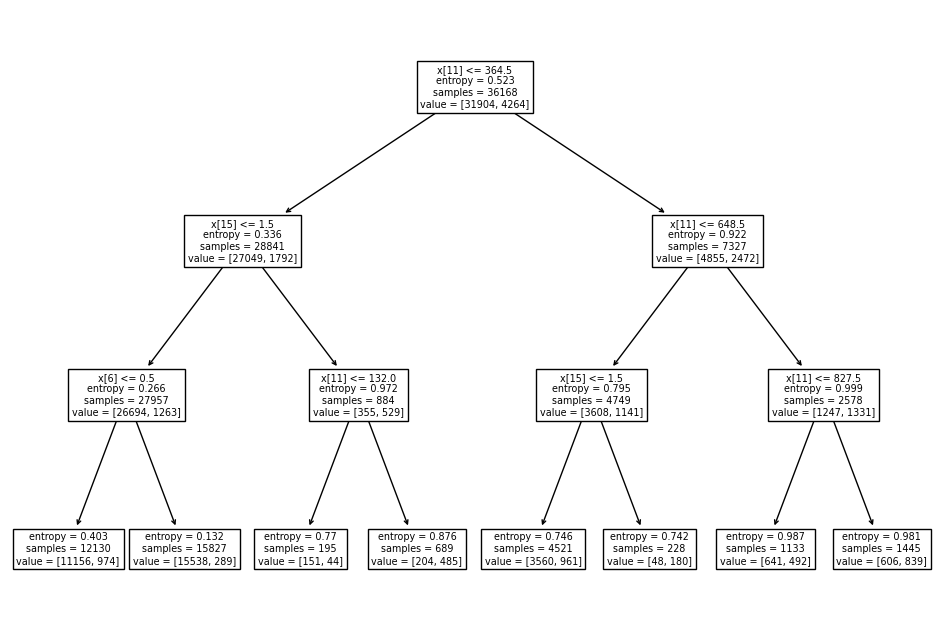

In [25]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(dt_classifier.fit(x_train, y_train))

**evaluation**

In [27]:



# Calculate performance metrics for test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
f_beta = fbeta_score(y_test, y_pred, beta=1, pos_label='yes')

cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(cm)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("F-beta Score (beta=1):", f_beta)

scores = cross_val_score(dt_classifier, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())


confusion matrix:
[[7807  211]
 [ 674  351]]
Accuracy: 0.902134247484242
Precision: 0.6245551601423488
Recall: 0.34243902439024393
F1 Score: 0.4423440453686201
F-beta Score (beta=1): 0.4423440453686201
Cross-Validation Scores: [0.88300343 0.89648308 0.88210573 0.64487945 0.82404335]
Mean Accuracy: 0.8261030081082048
Standard Deviation of Accuracy: 0.0939931237472712


### **Optimization for the Decision Tree classifier**


To optimize the Decision Tree classifier for the Bank Marketing dataset, we followed these steps:

1. Handling Imbalanced Data: The initial dataset was imbalanced, with fewer samples in the minority class ('yes') compared to the majority class ('no'). We addressed this issue by performing upsampling of the minority class using resampling with replacement. This created a balanced dataset by increasing the number of minority class samples to match the majority class samples.

2. Feature Scaling: To ensure that all features were on a similar scale, we applied feature scaling to the numerical features in the dataset. This was done using the StandardScaler from scikit-learn. Feature scaling helps improve the performance of the decision tree classifier by ensuring that no feature dominates the others due to differences in scale.

3. Hyperparameter Tuning: We used the GridSearchCV utility from scikit-learn for hyperparameter tuning. The hyperparameters considered for tuning were 'max_depth', 'criterion', and 'min_samples_split'. By creating a grid of parameter combinations and evaluating each combination using a 5-fold cross-validation, we selected the best parameters based on the provided scoring metric ('accuracy'). The best hyperparameters were then printed for further analysis.

the upsampling method is used to address class imbalance in the training set. It randomly samples with replacement from the minority class, increasing the number of samples to match the majority class. This approach helps create a balanced training set, enabling the model to learn effectively from both classes and improve performance on the minority class.

In [28]:

def precision_custom(estimator, x_test,y_test):
    y_pred=estimator.predict(x_test)
    precision =0
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    try:
      precision = tp / (tp + fp)
    except ZeroDivisionError:
      precision = 0.0
    return precision

In [29]:


df_tmp = X.copy()
df_tmp['target'] = y

# Separate the minority and majority class samples
df_minority = df_tmp[df_tmp['target'] == 'yes']
df_majority = df_tmp[df_tmp['target'] == 'no']

# Upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)

# Combine the upsampled minority class with the majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate the features (X) and target (y) from the upsampled dataset
X_upsampled = df_upsampled.drop('target', axis=1)
y_upsampled = df_upsampled['target']

x_train, x_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=25)

scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])


In [30]:

# Define hyperparameters for the decision tree
params = {
    'max_depth': range(3, 10),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 10)
}

# Perform hyperparameter tuning using grid search
dt_classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=params, scoring=precision_custom , cv=5)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best Decision Tree Hyperparameters:", best_params)


dt_classifier = DecisionTreeClassifier(**best_params)

start_time = time.time()
dt_classifier.fit(x_train, y_train)
end_time = time.time()
train_time = end_time - start_time

y_pred = dt_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

try:
    precision = tp / (tp + fp)
except ZeroDivisionError:
    precision = 0.0

recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = accuracy_score(y_test, y_pred)


print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
scores = cross_val_score(dt_classifier, X_upsampled, y_upsampled, cv=5, scoring=precision_custom)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Best Decision Tree Hyperparameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2}
Confusion matrix:
[[6711 1268]
 [1630 6360]]
Accuracy: 0.8185233890663159
Precision: 0.8337703198741478
Recall: 0.7959949937421777
F1 Score: 0.8144448713023433
Cross-Validation Scores: [0.81641574 0.7238085  0.6457126  0.6417533  0.7326495 ]
Mean Accuracy: 0.7120679277454702
Standard Deviation of Accuracy: 0.06449353934341592


In [31]:
model_results.loc[len(model_results)] = ['Decision Tree-supervised', train_time, accuracy, precision, recall, f1, scores.mean()]

In [39]:

feature_names = df.columns.tolist()
feature_names=feature_names[:-1]
dot_data = tree.export_graphviz(dt_classifier, out_file=None,
feature_names=feature_names,
class_names=["yes","no"],
filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("mytree")

'mytree.pdf'

# II. Semi-supervised learning Classification with Decision Trees


In [40]:

df = df_cleaned.copy()

X = df.drop('y', axis=1)
y = df['y']

#hyperparameters
labeled_ratio = 0.2  # Percentage of labeled samples
max_depth = 4
criterion = 'entropy'
random_state = 25
confidence_threshold = 0.8  # Set the confidence threshold for adding samples
iteration_limit = 5  # Set the maximum number of iterations
#------------------------------------


In [41]:

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=1 - labeled_ratio, random_state=random_state)

X_labeled_train, X_labeled_test, y_labeled_train, y_labeled_test = train_test_split(X_labeled, y_labeled, test_size=0.5, random_state=random_state)

print("#samples in X_labled")
print(len(X_labeled))

print("#samples in X_unlabled")
print(len(X_unlabeled))

print("#samples in y_labled")
print(len(y_labeled))


print("#samples in X_labeled_train")
print(len(X_labeled_train))
print("#samples in X_labeled_test")
print(len(X_labeled_test))

print("#samples in X_labeled_train")
print(len(y_labeled_train))

print("#samples in X_labeled_train")
print(len(y_labeled_test))



# Train the initial Decision Tree Classifier on the labeled training set

start_time = time.time()
semi_superviesed_classifier = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
semi_superviesed_classifier.fit(X_labeled_train, y_labeled_train)
end_time = time.time()
train_time = end_time - start_time

y_pred_labeled = semi_superviesed_classifier.predict(X_labeled_test)

# Calculate performance metrics for the labeled test set
accuracy_labeled = accuracy_score(y_labeled_test, y_pred_labeled)
precision_labeled = precision_score(y_labeled_test, y_pred_labeled, pos_label='yes')
recall_labeled = recall_score(y_labeled_test, y_pred_labeled, pos_label='yes')
f1_labeled = f1_score(y_labeled_test, y_pred_labeled, pos_label='yes')
f_beta_labeled = fbeta_score(y_labeled_test, y_pred_labeled, beta=1, pos_label='yes')

print("Performance Metrics for Labeled Test Set (Initial Round):")
print("Accuracy:", accuracy_labeled)
print("Precision:", precision_labeled)
print("Recall:", recall_labeled)
print("F1 Score:", f1_labeled)
print("F-beta Score:", f_beta_labeled)

# Use the trained model for semi-supervised learning on unlabeled data
for iteration in range(iteration_limit):
    print("Iteration:", iteration)
    print("Number of labeled samples:", len(X_labeled))

    # Predict labels for unlabeled data using the trained model
    y_pred_unlabeled = semi_superviesed_classifier.predict(X_unlabeled)

    # Get the confidence scores for the predicted labels
    confidence_scores = semi_superviesed_classifier.predict_proba(X_unlabeled).max(axis=1)

    # Find the samples with high confidence above the threshold
    high_confidence_indices = np.where(confidence_scores >= confidence_threshold)[0]

    if len(high_confidence_indices) == 0:
        print("No samples above the confidence threshold. Stopping iterations.")
        break
    print("#samples adding to labled")
    print(len( X_unlabeled.iloc[high_confidence_indices]))
    # Add the high confidence samples to the labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[high_confidence_indices]])
    y_labeled = pd.concat([y_labeled, pd.Series(y_pred_unlabeled[high_confidence_indices])])
    print("#sampoles removed from unlabled")
    print(len(X_unlabeled.index[high_confidence_indices]))
    # Remove the added samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[high_confidence_indices])
    # Retrain the Decision Tree Classifier on the updated labeled data
    semi_superviesed_classifier.fit(X_labeled, y_labeled)
y_pred_unlabeled = semi_superviesed_classifier.predict(X_unlabeled)
x_test_combined = X_labeled_test.append(X_unlabeled)

y_test_combined = y_labeled_test.append(pd.Series(y_pred_unlabeled))

y_pred_combined = semi_superviesed_classifier.predict(x_test_combined)

accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
precision_combined = precision_score(y_test_combined, y_pred_combined, pos_label='yes')
recall_combined = recall_score(y_test_combined, y_pred_combined, pos_label='yes')
f1_combined = f1_score(y_test_combined, y_pred_combined, pos_label='yes')
f_beta_combined = fbeta_score(y_test_combined, y_pred_combined, beta=1, pos_label='yes')

print("\nPerformance Metrics for Combined Test Set:")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)
print("F-beta Score:", f_beta_combined)
scores = cross_val_score(semi_superviesed_classifier, x_test_combined, y_test_combined, cv=5, scoring=precision_custom)

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

#samples in X_labled
9042
#samples in X_unlabled
36169
#samples in y_labled
9042
#samples in X_labeled_train
4521
#samples in X_labeled_test
4521
#samples in X_labeled_train
4521
#samples in X_labeled_train
4521
Performance Metrics for Labeled Test Set (Initial Round):
Accuracy: 0.9015704490157045
Precision: 0.6153846153846154
Recall: 0.33070866141732286
F1 Score: 0.4302176696542894
F-beta Score: 0.4302176696542894
Iteration: 0
Number of labeled samples: 9042
#samples adding to labled
31631
#sampoles removed from unlabled
31631
Iteration: 1
Number of labeled samples: 40673
#samples adding to labled
867
#sampoles removed from unlabled
867
Iteration: 2
Number of labeled samples: 41540
#samples adding to labled
3
#sampoles removed from unlabled
3
Iteration: 3
Number of labeled samples: 41543
No samples above the confidence threshold. Stopping iterations.


<ipython-input-41-3b38cf871446>:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_test_combined = X_labeled_test.append(X_unlabeled)
<ipython-input-41-3b38cf871446>:83: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test_combined = y_labeled_test.append(pd.Series(y_pred_unlabeled))



Performance Metrics for Combined Test Set:
Accuracy: 0.9488338014409574
Precision: 0.946257197696737
Recall: 0.8153252480705623
F1 Score: 0.875925377554042
F-beta Score: 0.875925377554042
Cross-Validation Scores: [0.77142857 0.92592593 0.94488189 0.9890411  1.        ]
Mean Accuracy: 0.9262554966017376
Standard Deviation of Accuracy: 0.08209593309918428


In [42]:
model_results.loc[len(model_results)] = ['Decision Tree- semi supervised', train_time, accuracy_combined, precision_combined, recall_combined, f1_combined, scores.mean()]


Despite a slight decrease in accuracy, the new model outperforms the previous model in terms of precision, recall, and F1 score. With a precision of 0.834 compared to 0.625, the new model makes fewer false positive predictions, making it more reliable for identifying potential subscribers in the imbalanced bank marketing dataset. Additionally, the higher recall of 0.796 compared to 0.342 indicates that the new model captures positive class instances more effectively. Overall, the improved precision, recall, and F1 score demonstrate that the new model offers a more accurate and valuable solution for optimizing marketing strategies and identifying potential customers likely to subscribe.

# III. Supervised learning Classification with a deep learning Model

 **initial attempt**

In [43]:

device = 'cuda'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fco = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fco(out)
        return out


In [45]:
# Initialize the neural network
input_size = X.shape[1]
hidden_size = 64
num_classes = len(y.unique())
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [46]:
num_epochs = 20

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

print("Training complete.")


Epoch 1/20, Loss: 0.7755
Epoch 2/20, Loss: 0.0865
Epoch 3/20, Loss: 0.0456
Epoch 4/20, Loss: 0.1768
Epoch 5/20, Loss: 0.1094
Epoch 6/20, Loss: 0.1444
Epoch 7/20, Loss: 0.4684
Epoch 8/20, Loss: 0.0928
Epoch 9/20, Loss: 0.1047
Epoch 10/20, Loss: 0.4045
Epoch 11/20, Loss: 0.1000
Epoch 12/20, Loss: 0.2006
Epoch 13/20, Loss: 0.2902
Epoch 14/20, Loss: 0.1640
Epoch 15/20, Loss: 0.1148
Epoch 16/20, Loss: 0.1529
Epoch 17/20, Loss: 0.1615
Epoch 18/20, Loss: 0.0162
Epoch 19/20, Loss: 0.0280
Epoch 20/20, Loss: 0.5789
Training complete.


In [47]:

test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    test_samples = 0
    true_labels = []

    predicted_labels = []

    for test_inputs, test_labels in test_loader:

        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_correct += torch.sum(test_predicted == test_labels).item()
        test_samples += test_labels.size(0)
        true_labels.extend(test_labels.tolist())
        predicted_labels.extend(test_predicted.tolist())

    test_loss /= test_samples
    test_accuracy = test_correct / test_samples
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0.0
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = accuracy_score(true_labels, predicted_labels)

print("Evaluation metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


Evaluation metrics:
Accuracy: 0.8954
Precision: 0.6087
Recall: 0.3721
F1-score: 0.4619


## **Optimization for the DNN model**


# Optimization Techniques:

To enhance the model's convergence speed, stability, and generalization capability, we employed various optimization techniques, taking into account the characteristics of the bank marketing dataset. These techniques are as follows:

1. **Handling Imbalanced Data:** The bank marketing dataset initially showed class imbalance, with fewer samples in the minority class ('yes') compared to the majority class ('no'). To address this issue, we performed upsampling of the minority class using resampling with replacement. By creating a balanced dataset, we ensure that the model is not biased towards the majority class and can learn effectively from both classes. This technique allows the model to capture patterns from the minority class more accurately, improving overall performance.

2. **Parameter Initialization:** We used Xavier uniform initialization to mitigate the vanishing or exploding gradient problem. This initialization technique sets the initial weights in a way that balances the scale of the gradients during backpropagation. By initializing the weights properly, we help the model converge faster and achieve better performance by preventing gradients from becoming too small or too large.

3. **Mini-Batch Stochastic Gradient Descent (SGD):** To address memory efficiency and accelerate convergence, we utilized mini-batch SGD. By processing small subsets (mini-batches) of the training data at each iteration, we reduce the memory requirements and enable efficient parallel processing. Mini-batch SGD strikes a balance between stochasticity and stability, allowing the model to converge more smoothly and efficiently.

4. **Batch Normalization Layer:** Batch normalization layers were added after each hidden layer in the model architecture. This technique is particularly beneficial for datasets with mixed categorical and numerical features, like the bank marketing dataset. Batch normalization stabilizes the optimization process by reducing the internal covariate shift, making the model less sensitive to the scale and distribution of input features. It improves convergence speed and overall model performance. By evaluating the inclusion or exclusion of batch normalization layers in the grid search, we can determine their impact on model performance and select the optimal configuration.

5. **Dropout Regularization:** Dropout regularization was applied after the input layer and each hidden layer. This technique randomly deactivates a fraction of neurons during training, which helps prevent overfitting. By dropout, the model learns more robust and generalizable features, especially useful when dealing with datasets that have many features or high dimensionality. Dropout regularization promotes better generalization by encouraging the model to rely on multiple subsets of neurons during training.

6. **Weight Decay (L2 Regularization):** Weight decay, also known as L2 regularization, was applied to the optimizer. It adds a penalty term to the loss function that encourages smaller weights in the model. This regularization technique helps prevent overfitting by discouraging large weight values, promoting a simpler and more generalized model. By including weight decay, we control the complexity of the model and improve its ability to generalize to unseen data.

8. **Performing Grid Search:**

To find the optimal configuration for our model, we performed a grid search. A grid search involves systematically testing different combinations of hyperparameters and architecture choices to identify the best performing configuration. Here's an overview of the hyperparameters and their ranges that were explored:

1. **Number of Hidden Layers:** During the grid search, we explored different numbers of hidden layers, including 1, 2, 3, and 4. This range allowed us to strike a balance between model complexity and the capacity to capture relevant patterns in the dataset. By testing various layer configurations, we aimed to find the optimal architecture that balances model capacity and avoids overfitting.

2. **Activation Function:** In the grid search, we considered two activation functions: ReLU and sigmoid. ReLU introduces non-linearity and helps the model learn complex relationships. Sigmoid is suitable for binary classification tasks, producing a probability-like output between 0 and 1. By comparing the performance of different activation functions, we aimed to select the one that best captures the underlying patterns in the bank marketing dataset.

3. **Loss Function:** For the binary classification task in the bank marketing dataset, we chose Cross Entropy Loss. This loss function effectively guides the model to optimize its parameters by measuring the dissimilarity between predicted probabilities and true labels. It is well-suited for training models to classify between two classes. By using Cross Entropy Loss, we aimed to maximize the model's ability to differentiate between 'yes' and 'no' outcomes.

4. **Batch Normalization Layer:** During the grid search, we evaluated the inclusion or exclusion of a batch normalization layer after each hidden layer. By comparing the model's performance with and without batch normalization, we could determine its impact on convergence speed and model performance. This allowed us to select the configuration that achieves the best trade-off between convergence and stability.

5. **Dropout:** The model included a dropout rate of 0.1. This dropout rate was selected to strike a balance between regularizing the model to reduce overfitting and preserving sufficient information for learning. By tuning the dropout rate, we aimed to prevent overfitting while still allowing the model to capture important patterns in the data.

**Model Hyperparameters:**

1. **Learning Rate:** We explored learning rates of 0.1 and 0.01 during the grid search. The learning rate determines the step size at which the optimizer updates the model's parameters during training. A higher learning rate can accelerate convergence but risks overshooting the optimal solution, while a lower learning rate can improve stability but may lead to slower convergence. By trying different learning rates, we aimed to find the optimal value that balances convergence speed and stability.

2. **Optimizer:** We selected the Adam optimizer for training the model. Adam combines the benefits of both AdaGrad and RMSProp optimizers by adapting the learning rate for each parameter individually. It is known for its efficiency and good generalization performance, making it a popular choice for deep learning models. By choosing Adam, we aimed to optimize both convergence speed and model performance.

3. **Batch Size:** We tested batch sizes of 32 and 64 during the grid search. The batch size determines the number of samples processed before updating the model's parameters. A smaller batch size introduces more noise into the gradient estimation but allows for more frequent updates, potentially leading to faster convergence. On the other hand, a larger batch size reduces the noise but updates the parameters less frequently. By testing different batch sizes, we aimed to find the optimal trade-off between convergence speed and memory efficiency.

4. **Number of Epochs:** We trained the model for 10 epochs. An epoch represents one complete pass through the entire training dataset. By training for multiple epochs, the model has the opportunity to learn from the data multiple times, refining its parameters and improving performance. We chose 10 epochs as a balance between allowing the model to learn sufficiently and avoiding overfitting.

5. **Early Stopping:** Early stopping was implemented with a patience of 5. This means that if the validation loss does not improve for 5 consecutive epochs, training is stopped early. Early stopping prevents the model from continuing to learn on non-representative or noisy patterns, helping to avoid overfitting and improve generalization.

By systematically exploring different combinations of these hyperparameters and architecture choices through the grid search, we aimed to find the optimal configuration that maximizes model performance on the bank marketing dataset. Taking into account the dataset characteristics and carefully selecting the


In [48]:

df_tmp = X.copy()
df_tmp['target'] = y
df_minority = df_tmp[df_tmp['target'] == 'yes']
df_majority = df_tmp[df_tmp['target'] == 'no']
# Upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)
# Combine the upsampled minority class with the majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X_upsampled = df_upsampled.drop('target', axis=1)
y_upsampled = df_upsampled['target']
# Split the data into training and test sets

X_trainval, X_test, y_trainval, y_test   = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=25)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)
# Normalize the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Convert the 'y' variable to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
# Convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

num_classes = len(y.unique())


In [49]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers, dropout_rate, activation,batch_norm):
        super(NeuralNetwork, self).__init__()
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.fc_output = nn.Linear(hidden_size, num_classes)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout_rate)
        if batch_norm==True:
          self.batchnorms = nn.ModuleList([nn.BatchNorm1d(hidden_size) for _ in range(num_hidden_layers)])
        self.batch_norm=batch_norm
    def forward(self, x):
        out = self.fc_input(x)
        out = self.activation(out)
        out = self.dropout(out)

        for i, layer in enumerate(self.hidden_layers):
            out = layer(out)
            out = self.batchnorms[i](out) if self.batch_norm else out
            out = self.activation(out)
            out = self.dropout(out)

        out = self.fc_output(out)
        return out


def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)


In [50]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **performing gridsearch to find best configuration for DNN**

**kindly note:** The following cell contains a complete grid search implementation that builds 64 models with different configurations. It explores various hyperparameters such as number of hidden layers, learning rate, activation function, the presence of a batch normalization layer, and batch size. For each model, it stores the evaluation results, including validation loss, validation accuracy, test loss, test accuracy, precision, recall, and F1 score.

Due to the extensive computation required(takes about 30 minutes), the grid search was run only once, and the results were saved in an Excel file. This file is available on GitHub and has been commented out in the notebook to avoid re-running the code and instead read the results from the pre-saved Excel file.

In [51]:


# # Define the hyperparameter combinations to search
# hyperparameters = {
#     'hidden_size': [64],
#     'num_hidden_layers': [1,2,3,4],
#     'dropout_rate': [0.1],
#     'lr': [0.01,0.1],
#     'activation': ['relu', 'sigmoid'],
#     'loss_function': ['CrossEntropyLoss'],
#     'batch_norm': [True,False],
#     'batch_size' : [32,64]
# }


# input_size = X_train.shape[1]
# num_classes = len(label_encoder.classes_)
# num_epochs = 10

# # Define the number of epochs to wait for early stopping
# patience = 5
# best_loss = float('inf')
# best_epoch = 0



# # Initialize variables to store the best hyperparameters and accuracy
# best_accuracy = 0.0
# best_hyperparameters = {}
# best_model = None
# grid_search_results=pd.DataFrame()
# gs_hidden_size=[]
# gs_num_hidden_layers=[]
# gs_lr=[]
# gs_test_accuracy=[]
# gs_test_loss=[]
# gs_validation_loss=[]
# gs_validation_accuracy=[]
# gs_percision=[]
# gs_recall=[]
# gs_f1=[]
# gs_batch_norm=[]
# gs_activation=[]
# gs_lossfunction=[]
# gs_dropout = []
# gs_batch_size=[]
# iteration=0
# combinations = itertools.product(*hyperparameters.values())

# # Get the number of iterations or length of the result
# num_iterations = len(list(combinations))


# # Perform grid search
# for params in itertools.product(*hyperparameters.values()):
#     if iteration%4==0:
#       print(f"Progress: {iteration}/{num_iterations}")
#     iteration = iteration+1

#     hyperparameter_values = dict(zip(hyperparameters.keys(), params))
#     batch_size =  hyperparameter_values['batch_size']
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)
#     model = NeuralNetwork(
#             input_size, hyperparameter_values['hidden_size'], num_classes,
#             hyperparameter_values['num_hidden_layers'], dropout_rate=hyperparameter_values['dropout_rate'],
#             activation=hyperparameter_values['activation'],batch_norm=hyperparameter_values['batch_norm']
#         )
#     model.apply(init_weights)
#     model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=hyperparameter_values['lr'], weight_decay=0.0001)
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         total_correct = 0
#         total_samples = 0
#         for i, (inputs, labels) in enumerate(train_loader):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total_correct += torch.sum(predicted == labels).item()
#             total_samples += labels.size(0)
#         model.eval()
#         with torch.no_grad():
#             val_loss = 0.0
#             val_correct = 0
#             val_samples = 0
#             for val_inputs, val_labels in val_loader:
#                 val_inputs = val_inputs.to(device)
#                 val_labels = val_labels.to(device)
#                 val_outputs = model(val_inputs)
#                 val_loss += criterion(val_outputs, val_labels).item()
#                 _, val_predicted = torch.max(val_outputs.data, 1)
#                 val_correct += torch.sum(val_predicted == val_labels).item()
#                 val_samples += val_labels.size(0)
#             val_loss /= val_samples
#             val_accuracy = val_correct / val_samples

#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 best_epoch = epoch
#             else:
#                 if epoch - best_epoch >= patience:
#                     # print("Early stopping. No improvement in validation loss for {} epochs.".format(patience))
#                     break

#         model.train()

#     # Evaluation on the test set
#     model.eval()
#     with torch.no_grad():
#         test_loss = 0.0
#         test_correct = 0
#         test_samples = 0
#         true_labels = []

#         predicted_labels = []

#         for test_inputs, test_labels in test_loader:
#             test_inputs = test_inputs.to(device)
#             test_labels = test_labels.to(device)
#             test_outputs = model(test_inputs)
#             test_loss += criterion(test_outputs, test_labels).item()
#             _, test_predicted = torch.max(test_outputs.data, 1)
#             test_correct += torch.sum(test_predicted == test_labels).item()
#             test_samples += test_labels.size(0)
#             true_labels.extend(test_labels.tolist())
#             predicted_labels.extend(test_predicted.tolist())

#         test_loss /= test_samples
#         test_accuracy = test_correct / test_samples
#         cm = confusion_matrix(true_labels, predicted_labels)
#         tn, fp, fn, tp = cm.ravel()
#         if (tp + fp) != 0:
#             precision = tp / (tp + fp)
#         else:
#             precision = 0.0
#         recall = tp / (tp + fn)
#         f1_score = 2 * (precision * recall) / (precision + recall)
#         accuracy = accuracy_score(true_labels, predicted_labels)

#     # save the results
#     gs_hidden_size.append(hyperparameter_values['hidden_size'])
#     gs_num_hidden_layers.append(hyperparameter_values['num_hidden_layers'])
#     gs_lr.append(hyperparameter_values['lr'])
#     gs_test_accuracy.append(test_accuracy)
#     gs_test_loss.append(test_loss)
#     gs_validation_loss.append(val_loss)
#     gs_validation_accuracy.append(val_accuracy)
#     gs_percision.append(precision)
#     gs_recall.append(recall)
#     gs_f1.append(f1_score)
#     gs_batch_norm.append(hyperparameter_values['batch_norm'])
#     gs_activation.append(hyperparameter_values['activation'])
#     gs_lossfunction.append(hyperparameter_values['loss_function'])
#     gs_dropout.append(hyperparameter_values['dropout_rate'])
#     gs_batch_size.append(hyperparameter_values['batch_size'])
#     # print(f'test Accuracy: {test_accuracy * 100:.2f}%')

#     if test_accuracy > best_accuracy:
#         best_accuracy = test_accuracy
#         best_hyperparameters = hyperparameter_values
#         best_model = model
# # Print the best hyperparameters and accuracy
# print("Best Hyperparameters:", best_hyperparameters)
# print("Best test Accuracy:", best_accuracy)
# grid_search_results['hidden_size']=gs_hidden_size
# grid_search_results['num_hidden_layers']=gs_num_hidden_layers
# grid_search_results['lr']=gs_lr
# grid_search_results['batch_norm'] = gs_batch_norm
# grid_search_results['hidden_size'] = gs_hidden_size
# grid_search_results['activation'] = gs_activation
# grid_search_results['loss function'] = gs_lossfunction
# grid_search_results['dropout'] = gs_dropout
# grid_search_results['validation_loss']=gs_validation_loss
# grid_search_results['validation_accuracy']=gs_validation_accuracy
# grid_search_results['test_loss']=gs_test_loss
# grid_search_results['test_accuracy']=gs_test_accuracy
# grid_search_results['percison']=gs_percision
# grid_search_results['recall']=gs_recall
# grid_search_results['f1_score']=gs_f1
# grid_search_results['batch_size']=gs_batch_size



In [52]:
# grid_search_results.to_csv('grid_search_results_2.csv', index=False)


In [53]:

file_path = 'grid_search_results_3.csv'

grid_search_results = pd.read_csv(file_path)


In [54]:
grid_search_results.head(100)

,hidden_size,num_hidden_layers,lr,batch_norm,activation,loss function,dropout,validation_loss,validation_accuracy,test_loss,test_accuracy,percison,recall,f1_score,batch_size
0,64,1,0.01,True,relu,CrossEntropyLoss,0.1,0.013732,0.811585,0.013415,0.821153,0.770324,0.915519,0.836669,32
1,64,1,0.01,True,relu,CrossEntropyLoss,0.1,0.006252,0.827789,0.006106,0.837310,0.812761,0.876846,0.843588,64
2,64,1,0.01,False,relu,CrossEntropyLoss,0.1,0.012797,0.822074,0.012423,0.831173,0.805376,0.873717,0.838156,32
3,64,1,0.01,False,relu,CrossEntropyLoss,0.1,0.006445,0.819178,0.006231,0.830985,0.794960,0.892365,0.840851,64
4,64,1,0.01,True,sigmoid,CrossEntropyLoss,0.1,0.012763,0.820039,0.012475,0.828355,0.808874,0.860200,0.833748,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,64,4,0.10,False,relu,CrossEntropyLoss,0.1,0.010851,0.508571,0.010859,0.499656,0.000000,0.000000,NaN,64
60,64,4,0.10,True,sigmoid,CrossEntropyLoss,0.1,0.017070,0.788728,0.017022,0.788904,0.748307,0.871089,0.805043,32
61,64,4,0.10,True,sigmoid,CrossEntropyLoss,0.1,0.007638,0.796164,0.007488,0.803995,0.786084,0.835670,0.810119,64
62,64,4,0.10,False,sigmoid,CrossEntropyLoss,0.1,0.021734,0.491429,0.021715,0.500344,0.500344,1.000000,0.666973,32


**visualizing results from the grid search**

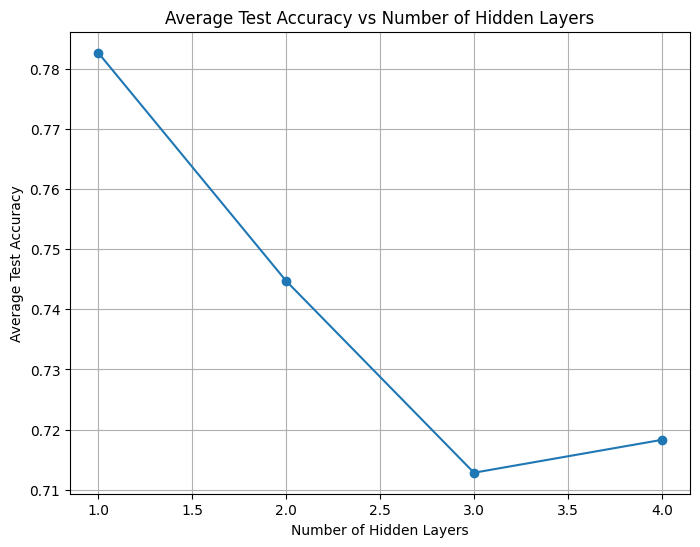

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract relevant columns
results = grid_search_results[['num_hidden_layers', 'test_accuracy']]

# Group by number of hidden layers and calculate mean test accuracy
grouped_results = results.groupby('num_hidden_layers')['test_accuracy'].mean()

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(grouped_results.index, grouped_results.values, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average Test Accuracy')
plt.title('Average Test Accuracy vs Number of Hidden Layers')
plt.grid(True)

plt.show()


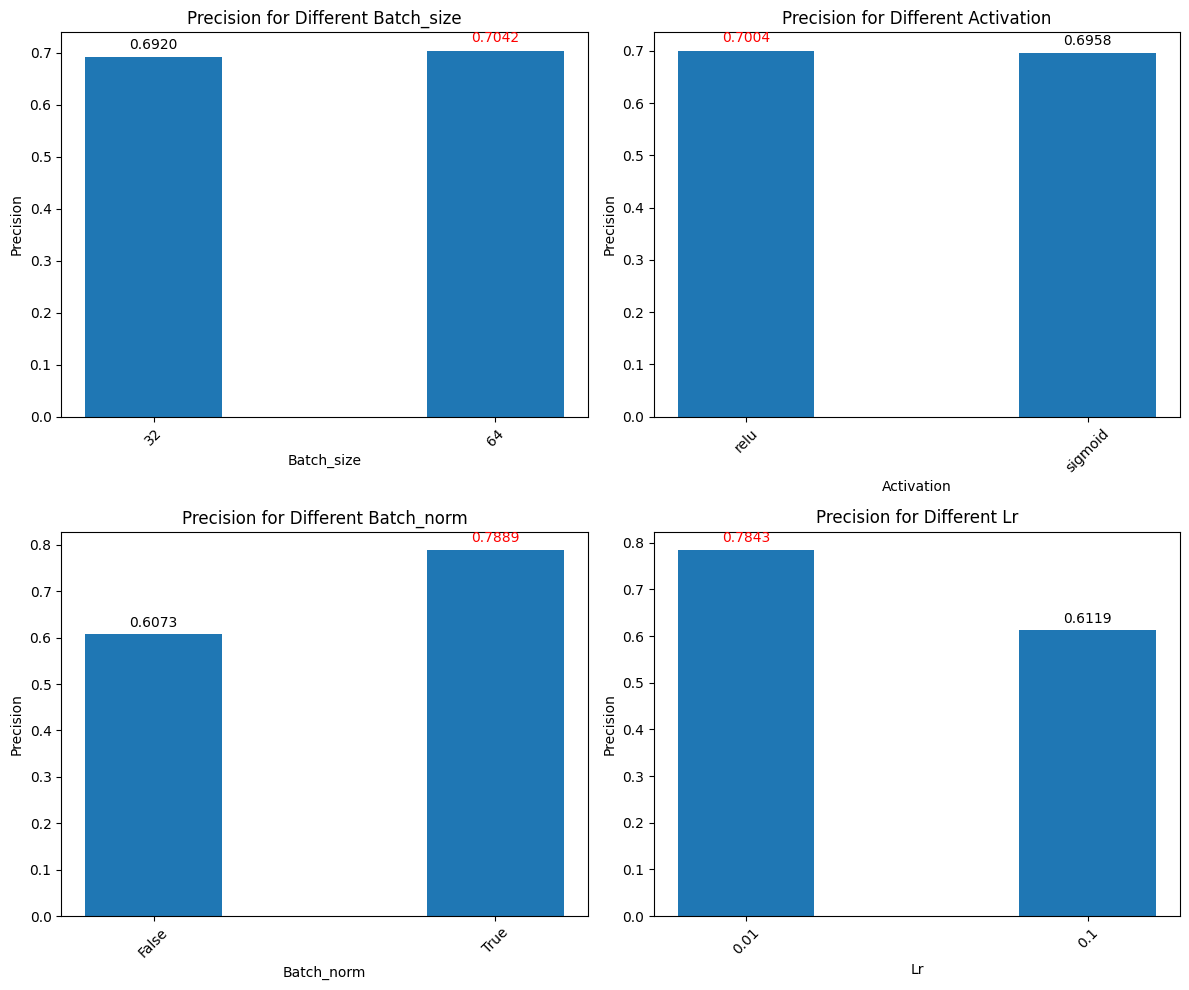

In [56]:


hyperparameters = ['batch_size', 'activation', 'batch_norm', 'lr']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.4)

for i, hyperparam in enumerate(hyperparameters):
    row = i // 2
    col = i % 2

    ax = axes[row, col]

    grouped_results = grid_search_results.groupby(hyperparam)['percison'].mean().reset_index()
    unique_values = grouped_results[hyperparam]
    x = np.arange(len(unique_values))
    width = 0.4

    bars = ax.bar(x, grouped_results['percison'], width=width)

    ax.set_xlabel(hyperparam.capitalize())
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision for Different {hyperparam.capitalize()}')
    ax.set_xticks(x)
    ax.set_xticklabels(unique_values)

    ax.tick_params(axis='x', rotation=45)

    max_value = max(grouped_results['percison'])
    for bar in bars:
        height = bar.get_height()
        if height == max_value:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.4f}', ha='center', va='bottom', color='red')
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


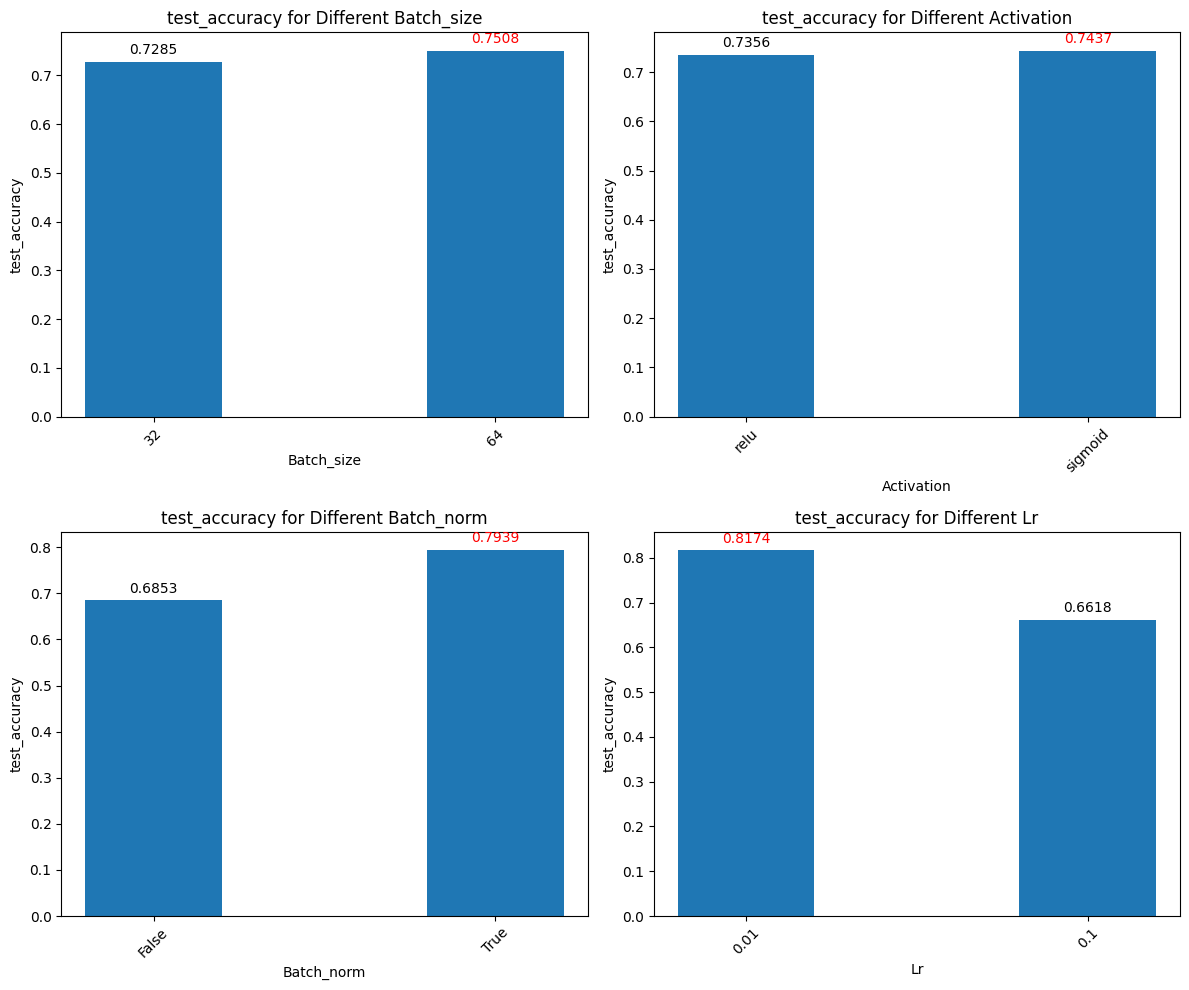

In [57]:

hyperparameters = ['batch_size', 'activation', 'batch_norm', 'lr']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.4)

for i, hyperparam in enumerate(hyperparameters):
    row = i // 2
    col = i % 2

    ax = axes[row, col]

    grouped_results = grid_search_results.groupby(hyperparam)['test_accuracy'].mean().reset_index()
    unique_values = grouped_results[hyperparam]
    x = np.arange(len(unique_values))
    width = 0.4

    bars = ax.bar(x, grouped_results['test_accuracy'], width=width)

    ax.set_xlabel(hyperparam.capitalize())
    ax.set_ylabel('test_accuracy')
    ax.set_title(f'test_accuracy for Different {hyperparam.capitalize()}')
    ax.set_xticks(x)
    ax.set_xticklabels(unique_values)

    ax.tick_params(axis='x', rotation=45)

    max_value = max(grouped_results['test_accuracy'])
    for bar in bars:
        height = bar.get_height()
        if height == max_value:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.4f}', ha='center', va='bottom', color='red')
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## **Training the model with the best configuration ( Final DNN model and results)**

In [58]:
grid_search_results['combined_score'] = 0.5 * grid_search_results['test_accuracy'] + 0.5 * grid_search_results['percison'] + 0.1 * grid_search_results['recall']

# # Calculate the third quartile for accuracy, precision, and recall
accuracy_threshold = np.percentile(grid_search_results['test_accuracy'], 0.90)
precision_threshold = np.percentile(grid_search_results['percison'], 0.95)
recall_threshold = np.percentile(grid_search_results['recall'], 0.75)
accuracy_threshold=0.82
precision_threshold=0.82
recall_threshold=0.75
filtered_results = grid_search_results[
    (grid_search_results['test_accuracy'] >= accuracy_threshold) &
    (grid_search_results['percison'] >= precision_threshold) &
    (grid_search_results['recall'] >= recall_threshold)
]

sorted_results = filtered_results.sort_values(by='combined_score', ascending=False)

top_2_models = sorted_results.head(2)

print("top_2_models")

for index, row in top_2_models.iterrows():
    print(f"Model {index + 1} Hyperparameters:")
    print("Hidden Size:", row['hidden_size'])
    print("Number of Hidden Layers:", row['num_hidden_layers'])
    print("Learning Rate:", row['lr'])
    print("Activation:", row['activation'])
    print("Batch Normalization:", row['batch_norm'])
    print("Batch Size:", row['batch_size'])
    print("accuracy:", row['test_accuracy'])
    print("percison:", row['percison'])
    print("recall:", row['recall'])

    print("-------------------------------------")



top_2_models
Model 20 Hyperparameters:
Hidden Size: 64
Number of Hidden Layers: 2
Learning Rate: 0.01
Activation: relu
Batch Normalization: False
Batch Size: 64
accuracy: 0.8356190118354312
percison: 0.8378038030474751
recall: 0.832665832290363
-------------------------------------
Model 49 Hyperparameters:
Hidden Size: 64
Number of Hidden Layers: 4
Learning Rate: 0.01
Activation: relu
Batch Normalization: True
Batch Size: 32
accuracy: 0.8333646439977457
percison: 0.8242667640258001
recall: 0.8476846057571965
-------------------------------------


In [59]:
best_result =  sorted_results.head(1)
best_hyperparameter_values={}
best_hyperparameter_values['hidden_size']=best_result['hidden_size'].item()

best_hyperparameter_values['num_hidden_layers']=best_result['num_hidden_layers'].item()
best_hyperparameter_values['batch_norm']=best_result['batch_norm'].item()
best_hyperparameter_values['activation']=best_result['activation'].item()
best_hyperparameter_values['lr']=best_result['lr'].item()
best_hyperparameter_values['batch_size']=best_result['batch_size'].item()
best_hyperparameter_values['dropout_rate']=best_result['dropout'].item()
best_hyperparameter_values['loss_function']=best_result['loss function'].item()


In [60]:
best_hyperparameter_values

{'hidden_size': 64,
 'num_hidden_layers': 2,
 'batch_norm': False,
 'activation': 'relu',
 'lr': 0.01,
 'batch_size': 64,
 'dropout_rate': 0.1,
 'loss_function': 'CrossEntropyLoss'}

**Final Model**

In [61]:


def calculate_flops(model, input_size):

    input_data = torch.randn(*input_size).to(device)
    flops, _ = profile(model, inputs=(input_data,))
    return flops


In [62]:


epoch_train_times = []

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
num_epochs = 10

patience = 5
best_loss = float('inf')
best_epoch = 0

hyperparameter_values = best_hyperparameter_values
batch_size = hyperparameter_values['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = NeuralNetwork(
    input_size, hyperparameter_values['hidden_size'], num_classes,
    hyperparameter_values['num_hidden_layers'], dropout_rate=hyperparameter_values['dropout_rate'],
    activation=hyperparameter_values['activation'], batch_norm=hyperparameter_values['batch_norm']
)

model.apply(init_weights)
model.to(device)

if hyperparameter_values['loss_function'] == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=hyperparameter_values['lr'], weight_decay=0.0001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = []

process_start_time = time.time()

epoch_start_time = 0

for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    epoch_start_time = time.time()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += torch.sum(predicted == labels).item()
        total_samples += labels.size(0)

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_samples = 0

        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct += torch.sum(val_predicted == val_labels).item()
            val_samples += val_labels.size(0)

        val_loss /= val_samples
        val_accuracy = val_correct / val_samples

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
        else:
            if epoch - best_epoch >= patience:
                print("Early stopping. No improvement in validation loss for {} epochs.".format(patience))
                break

    model.train()

    average_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    epochs.append(epoch + 1)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

process_end_time = time.time()

total_train_time = process_end_time - process_start_time

model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    test_samples = 0
    true_labels = []
    predicted_labels = []

    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_correct += torch.sum(test_predicted == test_labels).item()
        test_samples += test_labels.size(0)
        true_labels.extend(test_labels.tolist())
        predicted_labels.extend(test_predicted.tolist())

    test_loss /= test_samples
    test_accuracy = test_correct / test_samples
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0.0
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = accuracy_score(true_labels, predicted_labels)
input_size = (X_train.shape[1],)
flops = calculate_flops(model, input_size)

epoch_train_time = (process_end_time - process_start_time) / num_epochs

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Wall Clock Time for One Epoch of Training: {epoch_train_time:.2f} seconds')
print(f'Number of FLOPS: {flops}')


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Test Accuracy: 83.39%
Precision: 80.63%
Recall: 87.91%
F1 Score: 84.11%
Wall Clock Time for One Epoch of Training: 2.36 seconds
Number of FLOPS: 9344.0


In [73]:

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
num_epochs = 10
patience = 5
best_loss = float('inf')
best_epoch = 0
hyperparameter_values = best_hyperparameter_values
batch_size = hyperparameter_values['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Create an instance of NeuralNetClassifier so we can calculate cross entropy

model = NeuralNetClassifier(
    NeuralNetwork,
    module__input_size=input_size,
    module__hidden_size=hyperparameter_values['hidden_size'],
    module__num_classes=num_classes,
    module__num_hidden_layers=hyperparameter_values['num_hidden_layers'],
    module__dropout_rate=hyperparameter_values['dropout_rate'],
    module__activation=hyperparameter_values['activation'],
    module__batch_norm=hyperparameter_values['batch_norm'],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    optimizer__lr=hyperparameter_values['lr'],
    optimizer__weight_decay=0.0001,
    iterator_train__shuffle=True,
    device=device
)
# Create a scoring dictionary with the metrics you want to evaluate
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
X_train_numpy = X_train.values.astype(np.float32)
# X_train = X_train.values
scoring='accuracy'
# Perform cross-validation
cv_results = cross_validate(model, X_train_numpy, y_train_encoded, cv=KFold(n_splits=5, shuffle=True),
                            scoring=scoring, return_train_score=True)


# Extract the validation scores for each metric
test_accuracy = cv_results['test_score']


# Calculate the average scores across all folds
avg_test_accuracy = np.mean(test_accuracy)


print("Average Validation Accuracy:", avg_test_accuracy)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4712       0.8164        0.4252  1.6986
      2        0.4277       0.8193        0.4213  1.7048
      3        0.4251       0.8211        0.4135  1.3580
      4        0.4218       0.8192        0.4154  0.7967
      5        0.4168       0.8171        0.4117  0.7883
      6        0.4147       0.8271        0.3964  0.7850
      7        0.4101       0.8299        0.3963  0.7800
      8        0.4114       0.8296        0.3926  0.7796
      9        0.4118       0.8307        0.3918  0.7839
     10        0.4078       0.8282        0.3956  0.7861
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4639       0.8041        0.4273  2.0803
      2        0.4239       0.8167        0.4222  1.7315
      3        0.4196       0.8223        0.4051  1.2059
      4        0.4114       0.8

In [74]:
cv_results

{'fit_time': array([10.37194705, 16.82995772,  8.20668125,  7.93364239,  8.691818  ]),
 'score_time': array([0.13619947, 0.14257598, 0.22002673, 0.14484787, 0.14501548]),
 'test_score': array([0.8332681 , 0.82690802, 0.82866928, 0.82671233, 0.82495108]),
 'train_score': array([0.831091  , 0.83417319, 0.82928082, 0.82952544, 0.83016145])}

In [68]:
model_results.loc[len(model_results)] = ['Neural Network', train_time, accuracy, precision, recall, f1, avg_test_accuracy]


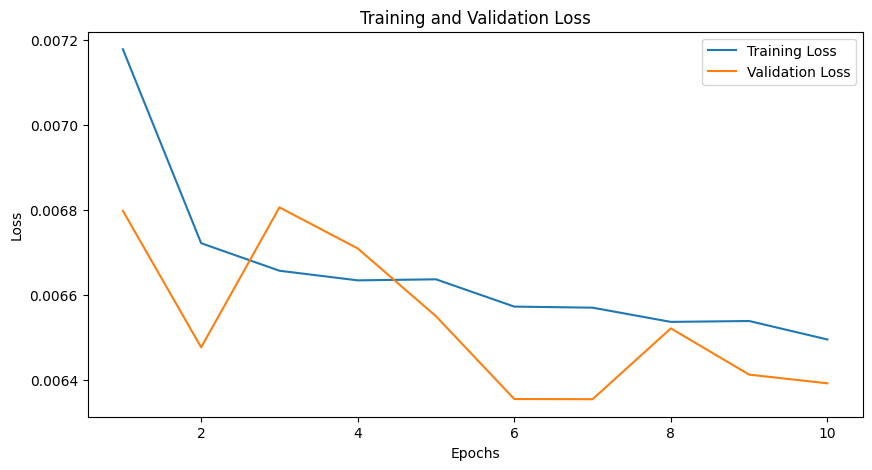

In [69]:

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


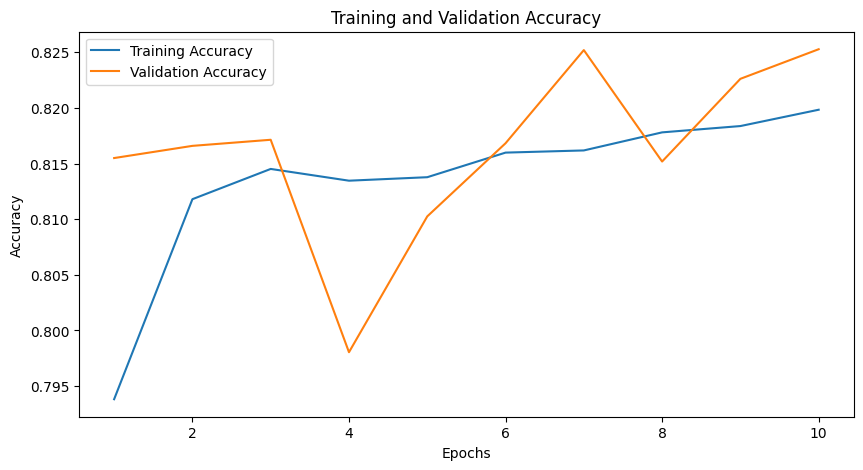

In [70]:

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In [71]:
# # Calculate ROC curve
# from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve

# test_probabilities = torch.softmax(test_outputs, dim=1).cpu().numpy()
# fpr, tpr, thresholds = roc_curve(true_labels, test_probabilities[:, 1])

# # Plotting ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label='ROC curve')
# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

# **Comparing results for different models**

In [76]:
model_results = model_results.rename(columns={'Train Time': 'Total_Training_Time (seconds)'})
model_results = model_results.rename(columns={'Cross Validation': 'Cross Validation (Accuracy)'})
model_results.head()

,Model,Total_Training_Time (seconds),Accuracy,Precision,Recall,F1 Score,Cross Validation (Accuracy)
0,Decision Tree-supervised,0.198915,0.818523,0.833770,0.795995,0.814445,0.712068
1,Decision Tree- semi supervised,0.020395,0.948834,0.946257,0.815325,0.875925,0.926255
3,Neural Network,0.020934,0.833866,0.806337,0.879099,0.841147,0.825284


In terms of performance, the semi-supervised decision tree model stands out with the highest accuracy, precision, and cross-validation accuracy among the three models. It shows great potential for accurately predicting the outcomes of the bank marketing dataset.